BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. 

The aim of this project is to build a predictive model and find out the sales of each product at a particular store.

In [57]:
import pandas as pd
import numpy as np

#Read files:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


Its generally a good idea to combine both train and test data sets into one, 
to perform feature engineering and then divide them later again. 

This saves the trouble of performing the same steps twice on test and train. 
Lets combine them into a dataframe ‘data’ with a ‘source’ column specifying where each observation belongs.

In [58]:
train.shape

(8523, 12)

In [59]:
print(train.shape, test.shape)
## test set has 12 cols bcoz it doesn't have the outcome variable

((8523, 12), (5681, 11))


In [60]:
# lets create a common dummy column with name 'source' in the both train and 
# test sets and that will have a const value 'train' and 'test' resp in the
# training and test sets, it will make it easier to separate the sets

train['source']='train'
test['source']='test'
train.head()
data = pd.concat([train, test],ignore_index=True)
# print(data.shape)

Lets check which columns contain missing values.

In [61]:
data.dtypes

Item_Fat_Content              object
Item_Identifier               object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Type                     object
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
Outlet_Identifier             object
Outlet_Location_Type          object
Outlet_Size                   object
Outlet_Type                   object
source                        object
dtype: object

In [62]:
for x in data.dtypes:
    print x

object
object
float64
float64
object
float64
float64
int64
object
object
object
object
object


In [63]:
for x in data.dtypes.index:
    print x

Item_Fat_Content
Item_Identifier
Item_MRP
Item_Outlet_Sales
Item_Type
Item_Visibility
Item_Weight
Outlet_Establishment_Year
Outlet_Identifier
Outlet_Location_Type
Outlet_Size
Outlet_Type
source


In [64]:
data.apply(lambda x: sum(x.isnull()))
## here lambda funct operates on the individual elements of a col/series

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
source                          0
dtype: int64

Note that the Item_Outlet_Sales is the target variable and missing values are ones in the test set. 
So we need not worry about it. 

But we’ll impute the missing values in Item_Weight and Outlet_Size in the data cleaning section.

Lets look at some basic statistics for numerical variables.

In [65]:
## Note describe method in df gives the stats of numeric variables
data.describe()
## summary() funct in R is more sophisticated in comparison

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,14204.000000,8523.000000,14204.000000,11765.000000,14204.000000
mean,141.004977,2181.288914,0.065953,12.792854,1997.830681
std,62.086938,1706.499616,0.051459,4.652502,8.371664
min,31.290000,33.290000,0.000000,4.555000,1985.000000
25%,94.012000,834.247400,0.027036,8.710000,1987.000000
50%,142.247000,1794.331000,0.054021,12.600000,1999.000000
75%,185.855600,3101.296400,0.094037,16.750000,2004.000000
max,266.888400,13086.964800,0.328391,21.350000,2009.000000


### Some observations:

1. Item_Visibility has a min value of zero. This makes no practical sense because when a product is being sold in a store, the visibility cannot be 0.
2. Outlet_Establishment_Years vary from 1985 to 2009. The values might not be apt in this form. Rather, if we can convert them to how old the particular store is, it should have a better impact on sales.
3. The lower ‘count’ of Item_Weight and Item_Outlet_Sales confirms the findings from the missing value check.
> Moving to nominal (categorical) variable, lets have a look at the number of unique values in each of them.

In [66]:
data.apply(lambda x: len(x.unique()))

Item_Fat_Content                 5
Item_Identifier               1559
Item_MRP                      8052
Item_Outlet_Sales             3494
Item_Type                       16
Item_Visibility              13006
Item_Weight                    416
Outlet_Establishment_Year        9
Outlet_Identifier               10
Outlet_Location_Type             3
Outlet_Size                      4
Outlet_Type                      4
source                           2
dtype: int64

- This tells us that there are 1559 products and 10 outlets/stores (which was also mentioned in problem statement). 
- Another thing that should catch attention is that Item_Type has 16 unique values. 
- Let’s explore further using the frequency of different categories in each nominal variable. 

I’ll exclude the ID and source variables for obvious reasons.

In [67]:
#Find categorical variables, which has data type 'object' in python
categorical_columns=[x for x in data.dtypes.index if data.dtypes[x]=='object']
#Exclude Item_ID, Outlet_ID, and source(a dummy col) cols:
categorical_columns = [x for x in categorical_columns if x not in
                       ['Item_Identifier','Outlet_Identifier','source']]

#Print frequency of each of the categories in the nominal variables
for col in categorical_columns:
    print('\nFrequency of Categories for varible %s' %col)
    print(data[col].value_counts())


Frequency of Categories for varible Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for varible Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of Categories for varible Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

Frequency of Categories for varible Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

F

The output gives us following observations:

- Item_Fat_Content: Some of ‘Low Fat’ values mis-coded as ‘low fat’ and ‘LF’. 
- Also, some of ‘Regular’ are mentioned as ‘regular’.

- In the variable Item_Type: Not all categories have substantial numbers and some of the appear quite related. It looks like combining them can give better results.
- Outlet_Type: Supermarket Type2 and Type3 can be combined. But we should check if that’s a good idea before doing it.

### Data Cleaning
This step typically involves imputing missing values and treating outliers. Though outlier removal is very important in regression techniques, advanced tree based algorithms are impervious to outliers. We’ll leave it for now. We’ll focus on the imputation step here, which is a very important step.

We’ll be using some Pandas library here.

##### Imputing Missing Values
We found two variables with missing values – Item_Weight and Outlet_Size. 

In [68]:
# Lets impute the Item_Weight by the average weight of the particular item:
### Item_weight is a continous variable, so we shall use average weight

#Determine the average weight per item:
item_avg_weight=data.pivot_table(values='Item_Weight',index='Item_Identifier')
# default is mean...it returns a panda series, with index name:'Item_Identifier'
# and mean of weights of all the items having the same 'Item_Identifier' as value

# Resources on reshapig and pivot_table in pandas
# https://pandas.pydata.org/pandas-docs/stable/reshaping.html
# We can also use groupby method in Pandas
print item_avg_weight.head(8)
type(item_avg_weight)
## We have 1559 unique 'Item_Identifier' but they are repeated obviously

Item_Identifier
DRA12    11.600
DRA24    19.350
DRA59     8.270
DRB01     7.390
DRB13     6.115
DRB24     8.785
DRB25    12.300
DRB48    16.750
Name: Item_Weight, dtype: float64


pandas.core.series.Series

In [69]:
## For example
type(item_avg_weight)

pandas.core.series.Series

In [70]:
#Get a series of boolean values specifying missing Item_Weight values
miss_bool = data['Item_Weight'].isnull() 
#will return a list of boolean values
## isnull(), but fillna(), dropna()
miss_bool[1:10]

1    False
2    False
3    False
4    False
5    False
6    False
7     True
8    False
9    False
Name: Item_Weight, dtype: bool

In [71]:
# concept
print data.loc[miss_bool,'Item_Weight'].head()
type(data.loc[miss_bool,'Item_Weight'])

# What we get is a panda series, in which the index is the index of missing
# Item_Weight in the original df, and values are the na's

7    NaN
18   NaN
21   NaN
23   NaN
29   NaN
Name: Item_Weight, dtype: float64


pandas.core.series.Series

In [72]:
# concept
print data.loc[miss_bool,'Item_Identifier'].head()
type(data.loc[miss_bool,'Item_Identifier'])

# What we get is a panda series, in which the index is the index of missing
# Item_Weight in the original df, and values are the corresp 'Item_Identifier'

7     FDP10
18    DRI11
21    FDW12
23    FDC37
29    FDC14
Name: Item_Identifier, dtype: object


pandas.core.series.Series

In [73]:
#Impute data and check #missing values before and after imputation to confirm
print('Orignal #missing: %d'% sum(miss_bool))

# ## Use the pivot table to impute the missing values
data.loc[miss_bool,'Item_Weight'] = data.loc[miss_bool,'Item_Identifier'].\
                                        apply(lambda x: item_avg_weight[x])

# (lambda x: item_avg_weight[x])..here input is the 'Item_Identifier' of 
# missing weight and output is the mean weight for the 'Item_Identifier'

print('Final #missing: %d'% sum(data['Item_Weight'].isnull()))

data.loc[miss_bool,'Item_Weight'].head()

# It works only in python2

Orignal #missing: 2439
Final #missing: 0


7     19.000
18     8.260
21     8.315
23    15.500
29    14.500
Name: Item_Weight, dtype: float64

In [74]:
data.loc[miss_bool,'Item_Identifier'].head()

7     FDP10
18    DRI11
21    FDW12
23    FDC37
29    FDC14
Name: Item_Identifier, dtype: object

In [75]:
item_avg_weight['FDP10']

19.0

- Since, Outlet_size is a nominal variable with 3 categories and Outlet_type is also a nominal variable with four categories.
- So, we shall try to derive the Outlet_size using the Outlet_type.

Lets impute Outlet_Size with the mode of the Outlet_Size for the particular type of outlet, in the other words by the most commmon size for a particular Outlet_type.

In [76]:
#Import mode function:
from scipy.stats import mode

#Determing the mode for each
outlet_size_mode = data.pivot_table(values='Outlet_Size', 
            columns='Outlet_Type',aggfunc=(lambda x:mode(x).mode[0]) )

# mode can be an array as there can be multiple values with high frequency
# That's why mode[0]
print 'Mode for each Outlet_Type:'
print outlet_size_mode

#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['Outlet_Size'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print '\nOrignal #missing: %d'% sum(miss_bool)
data.loc[miss_bool,'Outlet_Size'] = data.loc[miss_bool,'Outlet_Type'].\
                                apply(lambda x: outlet_size_mode[x])
print sum(data['Outlet_Size'].isnull())

Mode for each Outlet_Type:
Outlet_Type
Grocery Store         Small
Supermarket Type1     Small
Supermarket Type2    Medium
Supermarket Type3    Medium
Name: Outlet_Size, dtype: object

Orignal #missing: 4016
0


### Feature Engineering

We explored some nuances in the data in the data exploration section. Lets move on to resolving them and making our data ready for analysis. We will also create some new variables using the existing ones in this section.

Step 1: Consider combining Outlet_Type
During exploration, we decided to consider combining the Supermarket Type2 and Type3 variables. But is that a good idea? A quick way to check that could be to analyze the mean sales by type of store. If they have similar sales, then keeping them separate won’t help much.

In [77]:
data.pivot_table(values='Item_Outlet_Sales',index='Outlet_Type')
# default is mean

Outlet_Type
Grocery Store         339.828500
Supermarket Type1    2316.181148
Supermarket Type2    1995.498739
Supermarket Type3    3694.038558
Name: Item_Outlet_Sales, dtype: float64

This shows significant difference between them and we’ll leave them as it is. 

Step 2: Modify Item_Visibility

We noticed that the minimum value here is 0, which makes no practical sense. Lets consider it like missing information and impute it with mean visibility of that product.

In [78]:
#Determine average visibility of a product (irrespective of store)
visibility_avg = data.pivot_table(values='Item_Visibility', 
                                      index='Item_Identifier')
print visibility_avg.head(4)
print type(visibility_avg)

#Impute 0 values with mean visibility of that product:
miss_bool = (data['Item_Visibility'] == 0)

print '\nNumber of 0 values initially: %d'%sum(miss_bool)
data.loc[miss_bool,'Item_Visibility']=data.loc[miss_bool,'Item_Identifier'].\
                                        apply(lambda x: visibility_avg[x])
    
print 'Number of 0 values after modification: %d' \
                %sum(data['Item_Visibility'] == 0)

Item_Identifier
DRA12    0.034938
DRA24    0.045646
DRA59    0.133384
DRB01    0.079736
Name: Item_Visibility, dtype: float64
<class 'pandas.core.series.Series'>

Number of 0 values initially: 879
Number of 0 values after modification: 0


In [79]:
visibility_avg['DRA59']

0.13338352519999999

We hypothesized that products with higher visibility are likely to sell more. 
But along with comparing products on absolute terms, we should look at the visibility of the product in that particular store as compared to the mean visibility of that product across all stores. 
This will give some idea about how much importance was given to that product in a store as compared to other stores. We can use the ‘visibility_avg’ variable made above to achieve this.

### Create a new feature: For visibility factoring in store type

In [80]:
#Determine another variable with means ratio
data['Item_Visibility_MeanRatio'] = data.apply(lambda x: \
        x['Item_Visibility']/visibility_avg[x['Item_Identifier']], axis=1)

print data['Item_Visibility_MeanRatio'].describe()

count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_Visibility_MeanRatio, dtype: float64


### Create a new feature to condense the no of product category

Earlier we saw that the Item_Type variable has 16 categories which might prove to be very useful in analysis. So its a good idea to combine them. One way could be to manually assign a new category to each. 

But there’s a catch here. If we look at the Item_Identifier, i.e. the unique ID of each item, it starts with either FD, DR or NC. If we see the categories, these look like being Food, Drinks and Non-Consumables. 
> Another idea could be to combine categories based on sales. The ones with high average sales could be combined together.

In [81]:
#Get the first two characters of ID:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])

#Rename them to more intuitive categories:
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

### Create a new feature for the years of operation of a store
We wanted to make a new column depicting the years of operation of a store. 

In [82]:
#Years:
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

### Modify categories of the nominal variable Item_Fat_Content
We found typos and difference in representation in categories of Item_Fat_Content variable. 

In [83]:
#Change categories of low fat:
print 'Original Categories:'
print data['Item_Fat_Content'].value_counts()

print '\nModified Categories:'
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print data['Item_Fat_Content'].value_counts()

Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


But hang on, there are some non-consumables as well and a fat-content, in which case it doesn't matter and should not be specified for them. So we can also create a separate category for such kind of observations.

In [84]:
#Mark non-consumables as separate category in low_fat:
data.loc[data['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

# NOTE:
Before, we treat the categorical variable for regression, we can export the data for model building in R. We are good to go.


In [88]:
data1=data
#Drop the columns which have been converted to different types:
# data1.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=False)

#Divide into test and train:
train = data1.loc[data['source']=="train"]
test = data1.loc[data['source']=="test"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=False)
train.drop(['source'],axis=1,inplace=True)

#Export files as modified versions:
train.to_csv("train_ready4R.csv",index=False)
test.to_csv("test_ready4R.csv",index=False)

C:\Users\rkuma\Anaconda3\envs\DAND\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Treatment of categorical variable

Since scikit-learn accepts only numerical variables, We need to convert all categories of nominal variables into numeric types. Also, I wanted Outlet_Identifier as a variable as well. So I created a new variable ‘Outlet’ same as Outlet_Identifier and coded that. Outlet_Identifier should remain as it is, because it will be required in the submission file.

Lets start with coding all categorical variables as numeric using ‘LabelEncoder’ from sklearn’s preprocessing module.

In [38]:
#Import library:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#New variable for outlet
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])

var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size',
           'Item_Type_Combined','Outlet_Type','Outlet']

le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

One-Hot-Coding refers to creating dummy variables, one for each category of a categorical variable. 

- For example, the Item_Fat_Content has 3 categories – ‘Low Fat’, ‘Regular’ and ‘Non-Edible’. 
- One hot coding will remove this variable and generate 3 new variables. 
- Each will have binary numbers – 0 (if the category is not present) and 1(if category is present). 
- This can be done using ‘get_dummies’ function of Pandas.

In [39]:
#One Hot Coding:
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type',
                    'Outlet_Size','Outlet_Type','Item_Type_Combined','Outlet'])

In [40]:
data.head()

,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,source,Item_Visibility_MeanRatio,...,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,train,0.931078,...,0,0,0,0,0,0,0,0,0,1
1,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,train,0.933420,...,0,0,0,1,0,0,0,0,0,0
2,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,train,0.872790,...,0,0,0,0,0,0,0,0,0,1
3,FDX07,182.0950,732.3800,Fruits and Vegetables,0.017834,19.20,1998,OUT010,train,0.818182,...,1,0,0,0,0,0,0,0,0,0
4,NCD19,53.8614,994.7052,Household,0.009780,8.93,1987,OUT013,train,0.750000,...,0,1,0,0,0,0,0,0,0,0


In [41]:
data.dtypes

Item_Identifier               object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Type                     object
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
Outlet_Identifier             object
source                        object
Item_Visibility_MeanRatio    float64
Outlet_Years                   int64
Item_Fat_Content_0             uint8
Item_Fat_Content_1             uint8
Item_Fat_Content_2             uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
Item_Type_Combined_0           uint8
Item_Type_Combined_1           uint8
Item_Type_Combined_2           uint8
O

In [61]:
data[['Item_Fat_Content_0','Item_Fat_Content_1','Item_Fat_Content_2']].head()

,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2
0,1,0,0
1,0,0,1
2,1,0,0
3,0,0,1
4,0,1,0


### Exporting Data
Final step is to convert data back into train and test data sets.
Its generally a good idea to export both of these as modified data sets so that they can be re-used for multiple sessions. 

In [62]:
#Drop the columns which have been converted to different types:
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

#Divide into test and train:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

#Export files as modified versions:
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

C:\Users\rkuma\Anaconda3\envs\DAND\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rkuma\Anaconda3\envs\DAND\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Model Building

What we have to do finally is to predict the sales for a combination of item and outlet.

In [48]:
train = pd.read_csv("train_modified.csv")
test = pd.read_csv("test_modified.csv")

train.head()

,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Identifier,Item_Visibility_MeanRatio,Outlet_Years,Item_Fat_Content_0,Item_Fat_Content_1,...,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,FDA15,249.8092,3735.1380,0.016047,9.30,OUT049,0.931078,14,1,0,...,0,0,0,0,0,0,0,0,0,1
1,DRC01,48.2692,443.4228,0.019278,5.92,OUT018,0.933420,4,0,0,...,0,0,0,1,0,0,0,0,0,0
2,FDN15,141.6180,2097.2700,0.016760,17.50,OUT049,0.960069,14,1,0,...,0,0,0,0,0,0,0,0,0,1
3,FDX07,182.0950,732.3800,0.017834,19.20,OUT010,1.000000,15,0,0,...,1,0,0,0,0,0,0,0,0,0
4,NCD19,53.8614,994.7052,0.009780,8.93,OUT013,1.000000,26,0,1,...,0,1,0,0,0,0,0,0,0,0


### Create a generic function for to handle various algorithms

Lets define a generic function which takes the algorithm and data as input and makes the model, performs cross-validation and generates submission.

In [49]:
#Define target and ID columns:
target = 'Item_Outlet_Sales'

## IDcol to capture a combination of item and outlet
IDcol = ['Item_Identifier','Outlet_Identifier']

from sklearn import cross_validation, metrics
def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the training data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict on entire training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation:
    cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], \
                        dtrain[target], cv=20, scoring='mean_squared_error')
    
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print "\nModel Report"
    print "RMSE : %.4g" % np.sqrt(metrics.mean_squared_error( \
                            dtrain[target].values, dtrain_predictions))
    
    print "CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" \
    % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
    
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    
    #Export submission file:
    ## We want three cols in our output file
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission.to_csv(filename, index=False)

### Model1: Multi-variate Linear Regression Model



Model Report
RMSE : 1127
CV Score : Mean - 1129 | Std - 43.4 | Min - 1074 | Max - 1210


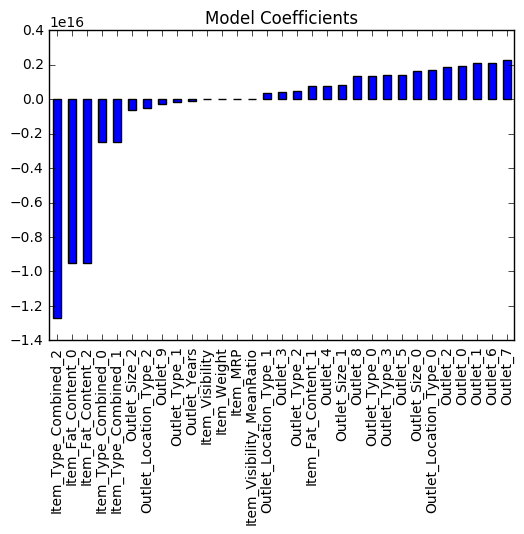

In [51]:
%matplotlib inline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
predictors = [x for x in train.columns if x not in [target]+IDcol]
# print predictors
alg1 = LinearRegression(normalize=True)
modelfit(alg1, train, test, predictors, target, IDcol, 'alg1.csv')
coef1 = pd.Series(alg1.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')

But if we notice the coefficients, they are very large in magnitude which signifies overfitting. To cater to this, lets use a ridge regression model.

Ridge and Lasso regression are powerful techniques generally used for creating parsimonious models in presence of a ‘large’ number of features. Here ‘large’ can typically mean either of two things:

> Large enough to enhance the tendency of a model to overfit (as low as 10 variables might cause overfitting)

> Large enough to cause computational challenges. With modern systems, this situation might arise in case of millions or billions of features.

#### Ridge Regression:
Performs L2 regularization, i.e. adds penalty equivalent to square of the magnitude of coefficients
Minimization objective = LS Obj + α * (sum of square of coefficients)
#### Lasso Regression:
Performs L1 regularization, i.e. adds penalty equivalent to absolute value of the magnitude of coefficients
Minimization objective = LS Obj + α * (sum of absolute value of coefficients)
Note that here ‘LS Obj’ refers to ‘least squares objective’, i.e. the linear regression objective without regularization.

### Model2: Ridge Regression:


Model Report
RMSE : 1129
CV Score : Mean - 1130 | Std - 44.6 | Min - 1076 | Max - 1217


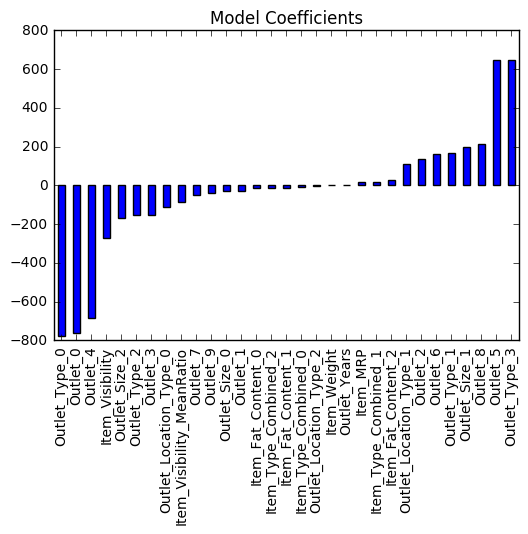

In [52]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg2 = Ridge(alpha=0.05,normalize=True)
modelfit(alg2, train, test, predictors, target, IDcol, 'alg2.csv')
coef2 = pd.Series(alg2.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients')

Though the regression coefficient look better now, the score is about the same.We can tune the parameters of the model for slightly better results but I don’t think there will be a significant improvement. Even the cross-validation score is same so we can’t expect way better performance.

### Model 3: Decision Tree Regression Model


Model Report
RMSE : 1058
CV Score : Mean - 1091 | Std - 45.42 | Min - 1003 | Max - 1186


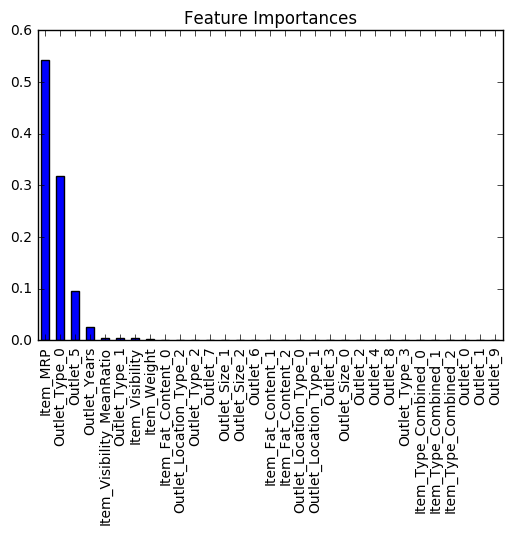

In [53]:
from sklearn.tree import DecisionTreeRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(alg3, train, test, predictors, target, IDcol, 'alg3.csv')

coef3 = pd.Series(alg3.feature_importances_, predictors). \
                                sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances')

- Here we can see that the RMSE is 1058 and the mean CV error is 1091. 
- This tells us that the model is slightly overfitting. 
- Lets try making a decision tree with just top 4 variables, a max_depth of 8 and min_samples_leaf as 150.


Model Report
RMSE : 1071
CV Score : Mean - 1096 | Std - 43.3 | Min - 1027 | Max - 1172


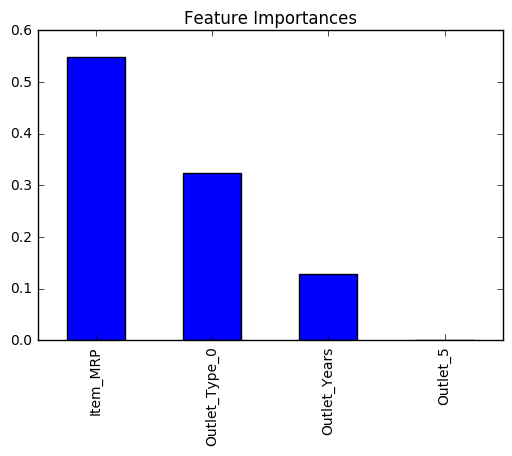

In [54]:
predictors = ['Item_MRP','Outlet_Type_0','Outlet_5','Outlet_Years']
alg4 = DecisionTreeRegressor(max_depth=8, min_samples_leaf=150)
modelfit(alg4, train, test, predictors, target, IDcol, 'alg4.csv')

coef4 = pd.Series(alg4.feature_importances_, predictors). \
                            sort_values(ascending=False)
coef4.plot(kind='bar', title='Feature Importances')

### Model4: Random Forest Regression Model


Model Report
RMSE : 1073
CV Score : Mean - 1084 | Std - 43.83 | Min - 1019 | Max - 1162


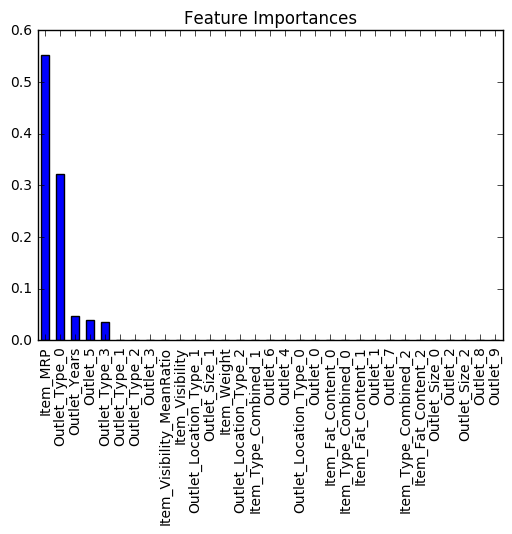

In [55]:
from sklearn.ensemble import RandomForestRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]

alg5 = RandomForestRegressor(n_estimators=200,max_depth=5, \
                             min_samples_leaf=100,n_jobs=4)

modelfit(alg5, train, test, predictors, target, IDcol, 'alg5.csv')

coef5 = pd.Series(alg5.feature_importances_, predictors).\
                                sort_values(ascending=False)

coef5.plot(kind='bar', title='Feature Importances')

This is a very small improvement but as our model gets better, achieving even minute improvements becomes exponentially difficult. Lets try another random forest with max_depth of 6 and 400 trees. Increasing the number of trees makes the model robust but is computationally expensive.


Model Report
RMSE : 1068
CV Score : Mean - 1083 | Std - 43.64 | Min - 1020 | Max - 1162


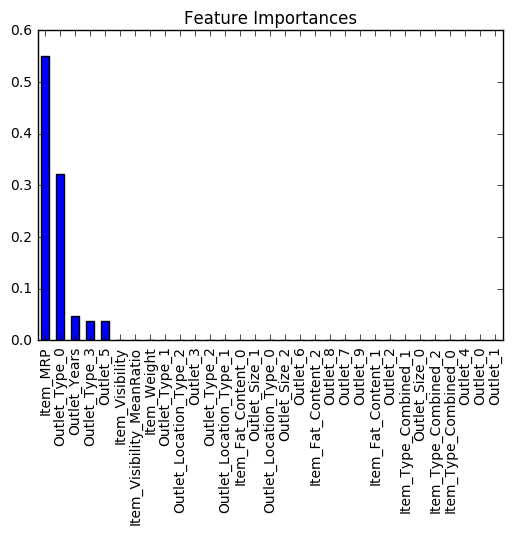

In [56]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg6 = RandomForestRegressor(n_estimators=400,max_depth=6, \
                             min_samples_leaf=100,n_jobs=4)
modelfit(alg6, train, test, predictors, target, IDcol, 'alg6.csv')

coef6 = pd.Series(alg6.feature_importances_, predictors).\
                            sort_values(ascending=False)
    
coef6.plot(kind='bar', title='Feature Importances')